In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
import seaborn as sns
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

# 1. Data

In [3]:
df = pd.read_csv("input/games.csv", delimiter=',')

In [4]:
df.head()

id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_eco  \
0  d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...         D10   
1  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...         B00   
2  e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...         C20   
3  d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...         D02   
4  e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...         C41   

                             opening_name  opening_ply  
0        Slav Defense: Exchange Variation            5  
1  Nimzowitsch Defense: Kennedy Variation            4  
2   King's Pawn Game: Leonardis Variation            3  
3  Queen's Pawn Game: Zukertort Variation            3  
4                        Philidor Defense            5

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [6]:
df.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

In [7]:
print(df.head())

         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_e

In [8]:
df.isnull().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

In [9]:
df.describe()

created_at  last_move_at         turns  white_rating  black_rating  \
count  2.005800e+04  2.005800e+04  20058.000000  20058.000000  20058.000000   
mean   1.483617e+12  1.483618e+12     60.465999   1596.631868   1588.831987   
std    2.850151e+10  2.850140e+10     33.570585    291.253376    291.036126   
min    1.376772e+12  1.376772e+12      1.000000    784.000000    789.000000   
25%    1.477548e+12  1.477548e+12     37.000000   1398.000000   1391.000000   
50%    1.496010e+12  1.496010e+12     55.000000   1567.000000   1562.000000   
75%    1.503170e+12  1.503170e+12     79.000000   1793.000000   1784.000000   
max    1.504493e+12  1.504494e+12    349.000000   2700.000000   2723.000000   

        opening_ply  
count  20058.000000  
mean       4.816981  
std        2.797152  
min        1.000000  
25%        3.000000  
50%        4.000000  
75%        6.000000  
max       28.000000

In [10]:
from sklearn.preprocessing import LabelEncoder

categorical_column = ['rated', 'winner', 'victory_status']
                      

for i in categorical_column:
    le = LabelEncoder()
    df[i] = le.fit_transform(df[i])
print(df.head())

         id  rated    created_at  last_move_at  turns  victory_status  winner  \
0  TZJHLljE      0  1.504210e+12  1.504210e+12     13               2       2   
1  l1NXvwaE      1  1.504130e+12  1.504130e+12     16               3       0   
2  mIICvQHh      1  1.504130e+12  1.504130e+12     61               1       2   
3  kWKvrqYL      1  1.504110e+12  1.504110e+12     61               1       2   
4  9tXo1AUZ      1  1.504030e+12  1.504030e+12     95               1       2   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               mov

# 2.Distribution Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c0118e0>,
      dtype=object)

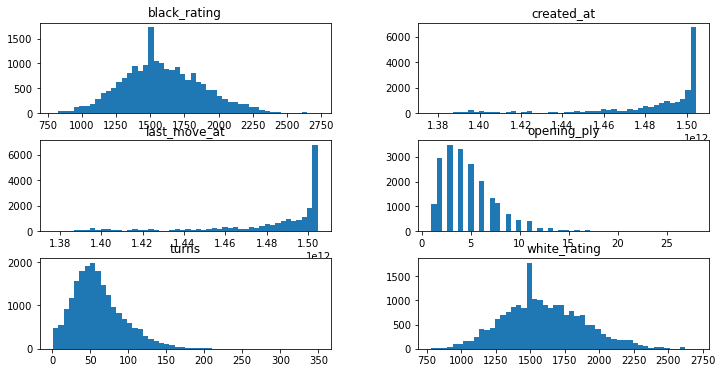

In [11]:
df[['black_rating', 'white_rating', 'turns', 'opening_ply', 'created_at', 'last_move_at']].hist(figsize=(12, 6), bins=50, grid=False)

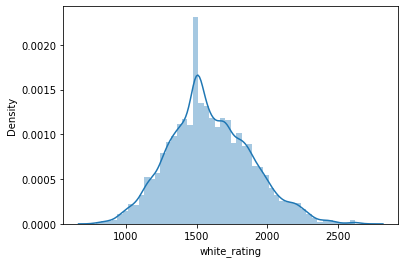

In [12]:
sns.distplot(df['white_rating'])

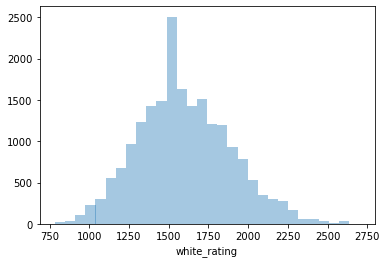

In [13]:
sns.distplot(df['white_rating'],kde=False,bins=30)

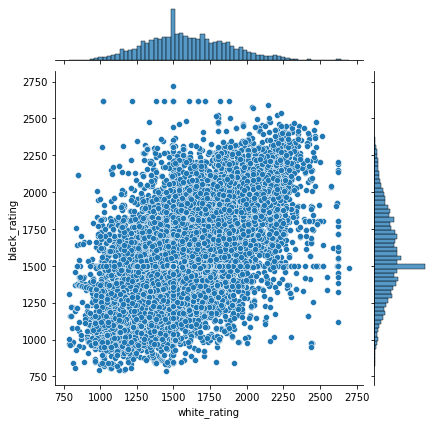

In [14]:
sns.jointplot(x='white_rating',y='black_rating',data=df,kind='scatter')

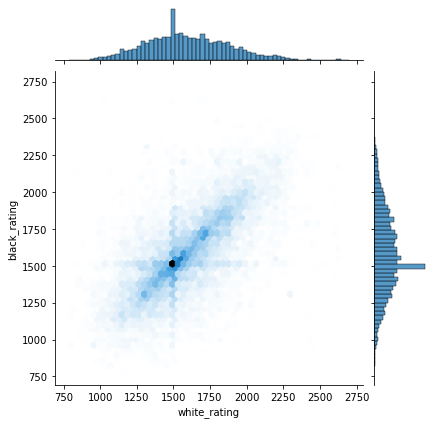

In [15]:
sns.jointplot(x='white_rating',y='black_rating',data=df,kind='hex')

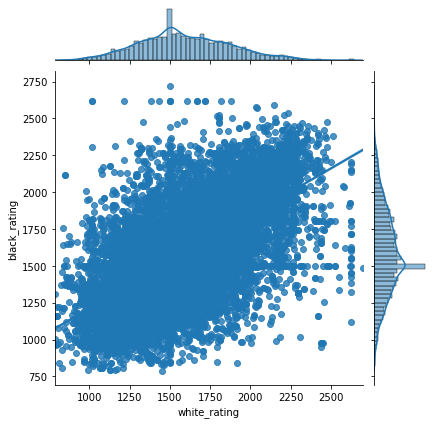

In [16]:
sns.jointplot(x='white_rating',y='black_rating',data=df,kind='reg')

In [17]:
sns.pairplot(df)

In [18]:
sns.pairplot(df,hue='winner',palette='coolwarm')

# 3.Categorical Plots

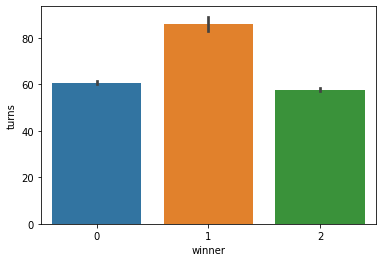

In [19]:
sns.barplot(x='winner',y='turns',data=df)

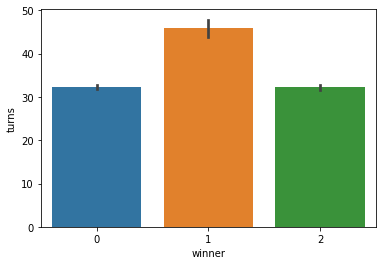

In [20]:
sns.barplot(x='winner',y='turns',data=df,estimator=np.std)

In [21]:
sns.countplot(x='winner',data=df)

In [22]:
sns.boxplot(x="winner", y="turns", data=df,palette='rainbow')

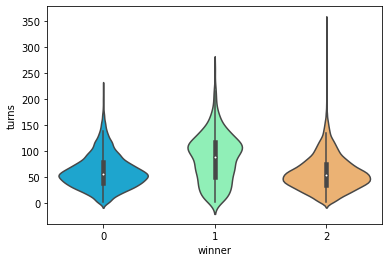

In [23]:
sns.violinplot(x="winner", y="turns", data=df,palette='rainbow')

# 4.Matrix plot

In [24]:
df.corr()

rated  created_at  last_move_at     turns  victory_status  \
rated           1.000000   -0.001171     -0.001176  0.090698        0.004556   
created_at     -0.001171    1.000000      1.000000  0.083185        0.012867   
last_move_at   -0.001176    1.000000      1.000000  0.083196        0.012865   
turns           0.090698    0.083185      0.083196  1.000000       -0.214608   
victory_status  0.004556    0.012867      0.012865 -0.214608        1.000000   
winner         -0.006722   -0.019503     -0.019503 -0.044346        0.002210   
white_rating    0.003284    0.116170      0.116172  0.129753        0.110852   
black_rating    0.032655    0.133316      0.133318  0.160467        0.109694   
opening_ply    -0.001906    0.100201      0.100203  0.055999        0.063809   

                  winner  white_rating  black_rating  opening_ply  
rated          -0.006722      0.003284      0.032655    -0.001906  
created_at     -0.019503      0.116170      0.133316     0.100201  
last_move_at   -0.019503      0.116172      0.133318     0.100203  
turns          -0.044346      0.129753      0.160467     0.055999  
victory_status  0.002210      0.110852      0.109694     0.063809  
winner          1.000000      0.141700     -0.166815     0.020669  
white_rating    0.141700      1.000000      0.634171     0.277379  
black_rating   -0.166815      0.634171      1.000000     0.255396  
opening_ply     0.020669      0.277379      0.255396     1.000000

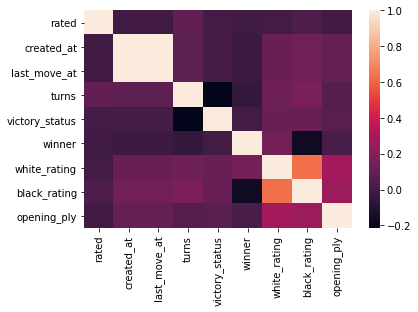

In [25]:
sns.heatmap(df.corr())

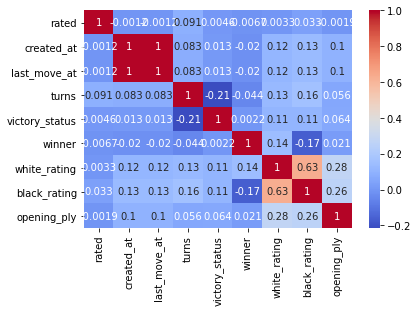

In [26]:
sns.heatmap(df.corr(),cmap='coolwarm',annot=True)

# 5. Grids

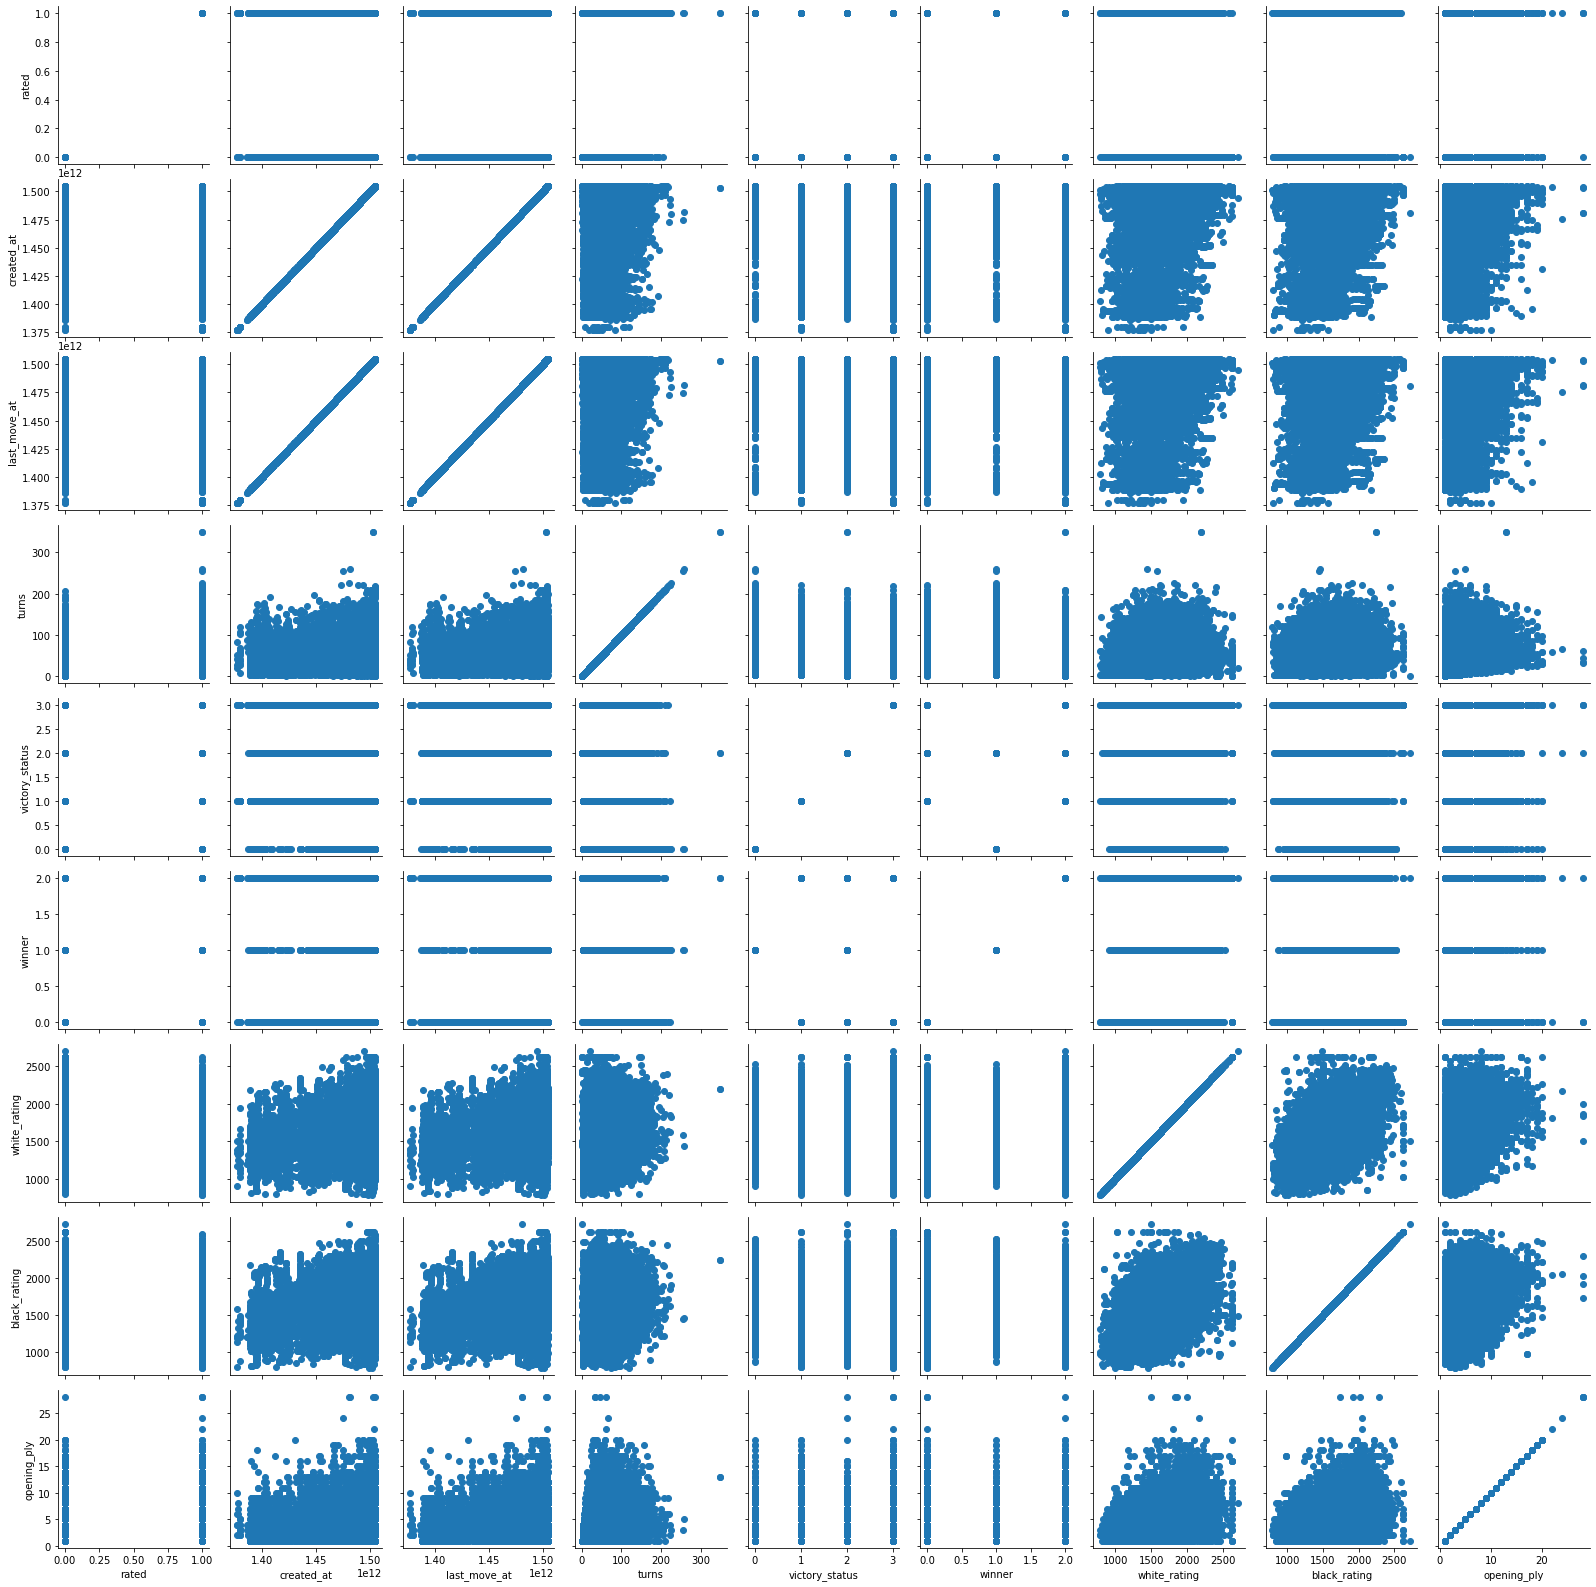

In [27]:
g = sns.PairGrid(df)
g.map(plt.scatter)

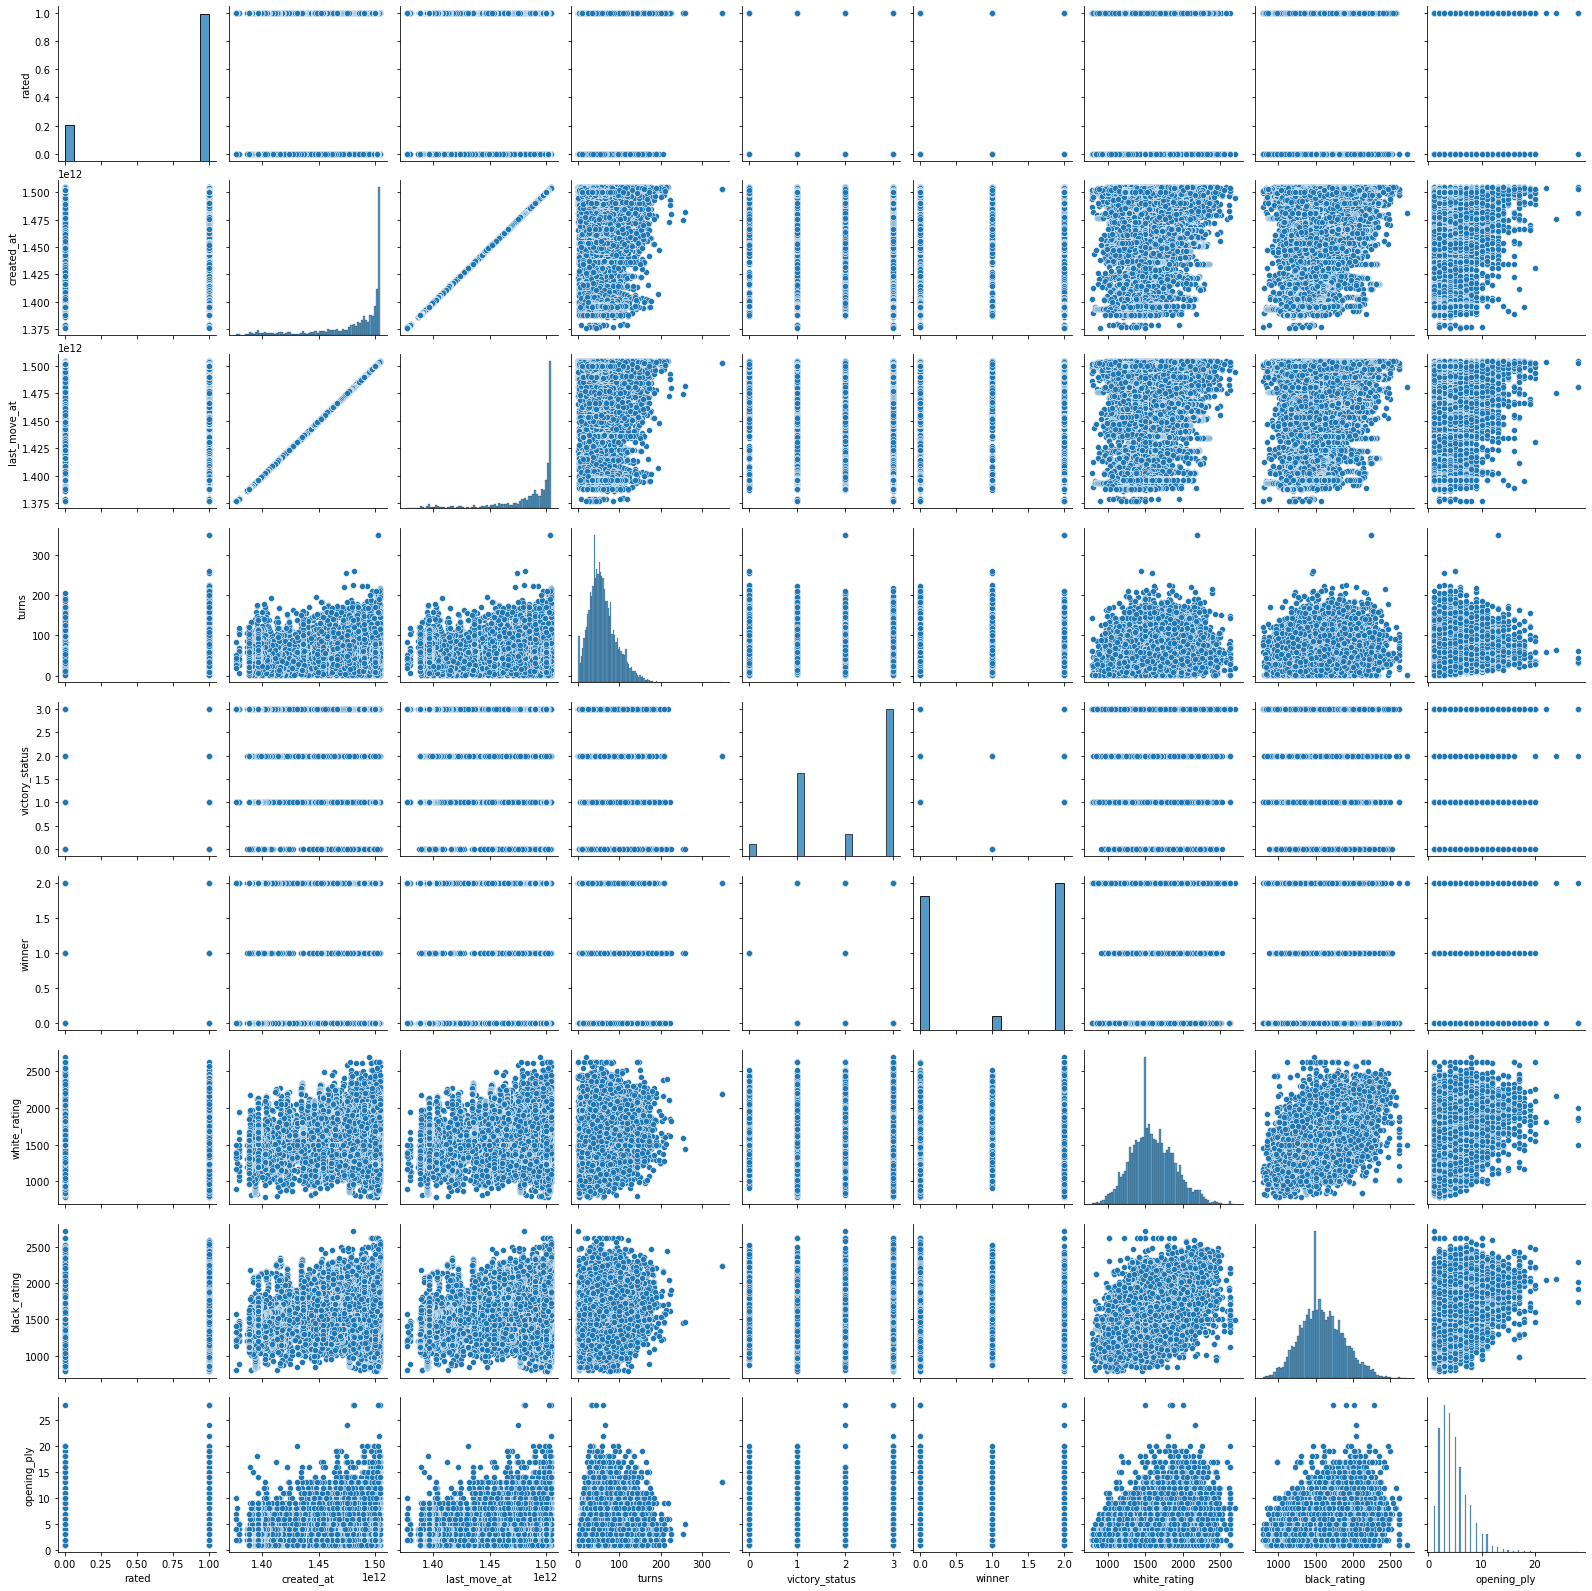

In [28]:
sns.pairplot(df)

# 6. Pandas with Data Visualization


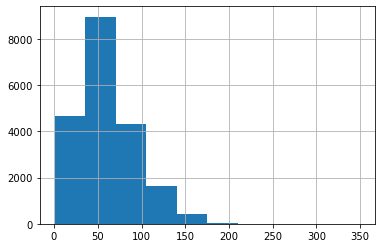

In [29]:
df['turns'].hist();

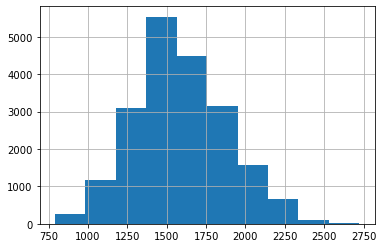

In [30]:
df['black_rating'].hist()

In [31]:
plt.style.use('ggplot')
df['white_rating'].hist()

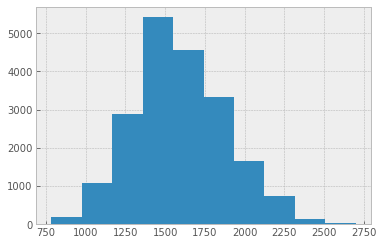

In [32]:
plt.style.use('bmh')
df['white_rating'].hist()

In [33]:
plt.style.use('dark_background')
df['turns'].hist()

In [34]:
plt.style.use('ggplot')
df.plot.area(alpha=0.4)

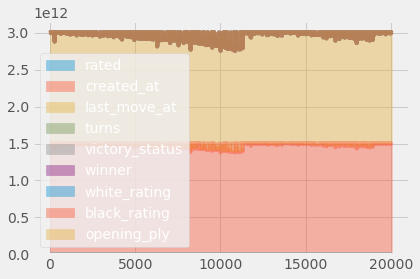

In [35]:
plt.style.use('fivethirtyeight')
df.plot.area(alpha=0.4)